In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
import copy
import os
import time


# readable_labels = {
#      0  : "day",
#      1  : "season",
#      2  : "year",
#      3  : "month",
#      4  : "hour",

#      5  : "holiday",
#      6  : "day of week",
#      7  : "workday",

#      8  : "weather",
#      9  : "temperature",
#      10 : "feels_like_temp",
#      11 : "humidity",
#      12 : "wind speed",
# }

readable_labels = ['fixed acidity', 'volatile acidity', 'citric acid',
                   'residual sugar', 'chlorides', 'free sulfur dioxide',
                   'total sulfur dioxide', 'density', 'pH', 'sulphates',
                   'alcohol', 'quality']



%load_ext autoreload
%autoreload 2

NEED TO DOWNLOAD BIKE SHARING DATASET FROM

https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

AND EXTRACT "hour.csv" INTO THE "data/" FOLDER

In [2]:
from data_loader import preprocess_bike_sharing_dataset
preprocess_bike_sharing_dataset()

--- processed and saved ---


## Training vanilla MLP

In [3]:
from models import *
from data_loader import loadDataset


#batch size, epochs, learning rate
BS = 32
EP = 300
LR = 5e-3

data_path = 'data/'
trnX1,trnY1,    tstX,tstY = loadDataset(data_path)
print(trnX1.shape)

#whitening the input and output data
trnX1 = trnX1 - np.expand_dims(np.mean(trnX1,axis=0),axis=0)
trnX1 = trnX1 / np.expand_dims(np.sqrt(np.mean(trnX1**2,axis=0)),axis=0)
trnX1_og = trnX1    
trnY1_og = trnY1[:,None]-4.42

device = torch.device("cuda:0")
device = torch.device("cpu")


if True:
    mn=0
    M_NUM = trnX1_og.shape[0]
    rand_indices = np.random.permutation(M_NUM)
    per = .7
    M_TRN_NUM = int(M_NUM*per)
    trnX1 = trnX1_og[rand_indices[:M_TRN_NUM]]
    trnY1 = trnY1_og[rand_indices[:M_TRN_NUM]]
    valX1 = trnX1_og[rand_indices[M_TRN_NUM:]]
    valY1 = trnY1_og[rand_indices[M_TRN_NUM:]]


    trn_data1 = TensorDataset(torch.from_numpy(trnX1).float().to(device),
                              torch.from_numpy(trnY1).float().to(device))
    trn_loader1 =DataLoader(dataset=trn_data1, batch_size=BS,shuffle=True)

    trn_tensor = torch.from_numpy(trnX1).float().to(device)
    val_tensor = torch.from_numpy(valX1).float().to(device)


    sizes = [11,256,128,64,1] #what do these 4 numbers mean (changed the 0th entry from 13 to 10)
    net1 = MLP(sizes).to(device)
    opt1 = optim.Adagrad(net1.parameters(), lr = LR)
    
    
    
    all_trn_accs = np.zeros(EP)
    all_val_accs = np.zeros(EP)
    all_losses = np.zeros((EP,len(trn_loader1),7))
    all_trn_losses = np.zeros((EP,len(trn_loader1)))
    all_val_losses = np.zeros(EP)

    best_val_score = -100
    best_net = None

    full_training_start_time = time.time()
    for k in range(EP):
        print('Epoch',k)
        start_time = time.time()

        
        #---TRAINING PHASE---
        for j,(x_batch,y_batch) in enumerate(trn_loader1):
            net1.train()
            logits = net1(x_batch)
            dnn_logits,gam_logits,shape_loss = net1(x_batch)
            logits = dnn_logits + gam_logits
            

            l1_reg = torch.zeros(1).to(device)
            all_linear_params = net1.collectParameters()
            lambda1 = 5e-5 
            l1_reg = lambda1 * torch.norm(all_linear_params, 1)


            mseloss = (y_batch.narrow(1,0,1) - logits.narrow(1,0,1))**2
            mseloss = torch.mean(mseloss)
            mseloss = mseloss
            
            
            all_trn_losses[k,j] = mseloss.item()
            loss = mseloss + l1_reg
            loss.backward()
            all_losses[k,j,0] = loss.item()
            all_losses[k,j,1] = mseloss.item()
            all_losses[k,j,2] = l1_reg.item()
            
            
            opt1.step()
            opt1.zero_grad()
        print('mean training loss\t',np.mean(all_losses[k,:,0]))
        
        
        #---VALIDATION PHASE---
        print('epoch',k,'\'')
        net1.eval()
        #training accuracy
        logits = net1(trn_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_trn_accs[k] = np.mean(((trnY1[:,0])-logits)**2)
        #validation accuracy
        logits = net1(val_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_val_accs[k] = np.mean(((valY1[:,0])-logits)**2)
        all_val_losses[k] = np.mean(((valY1[:,0])-logits)**2)
        print('MSE for train and val\t',all_trn_accs[k],'\t',all_val_accs[k])


        
        if k%1==0:
            val_score = -all_val_accs[k]
            if val_score > best_val_score:
                best_val_score = val_score
                best_net = copy.deepcopy(net1)

        end_time = time.time()
        print("--- %s seconds in epoch ---" % round((end_time - start_time),3))
        print()
    print('FULLY TRAINED USING',time.time()-full_training_start_time,'seconds')
    print()
    

(1279, 11)


/Users/williamchang/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0
mean training loss	 0.7602809965610504
epoch 0 '
MSE for train and val	 0.4876515150315265 	 0.4998472549417701
--- 1.367 seconds in epoch ---

Epoch 1
mean training loss	 0.5628188752702304
epoch 1 '
MSE for train and val	 0.4495793286122227 	 0.4552139389177546
--- 0.273 seconds in epoch ---

Epoch 2
mean training loss	 0.5294169868741717
epoch 2 '
MSE for train and val	 0.4471691307195852 	 0.45208894519169784
--- 0.169 seconds in epoch ---

Epoch 3
mean training loss	 0.5150794578450066
epoch 3 '
MSE for train and val	 0.41100716091076733 	 0.41863031907592996
--- 0.146 seconds in epoch ---

Epoch 4
mean training loss	 0.49368621302502497
epoch 4 '
MSE for train and val	 0.4053251574744069 	 0.41124704135766654
--- 0.131 seconds in epoch ---

Epoch 5
mean training loss	 0.4827456548810005
epoch 5 '
MSE for train and val	 0.38539379058655177 	 0.39654976019841087
--- 0.131 seconds in epoch ---

Epoch 6
mean training loss	 0.47577483632734846
epoch 6 '
MSE for train and val	 

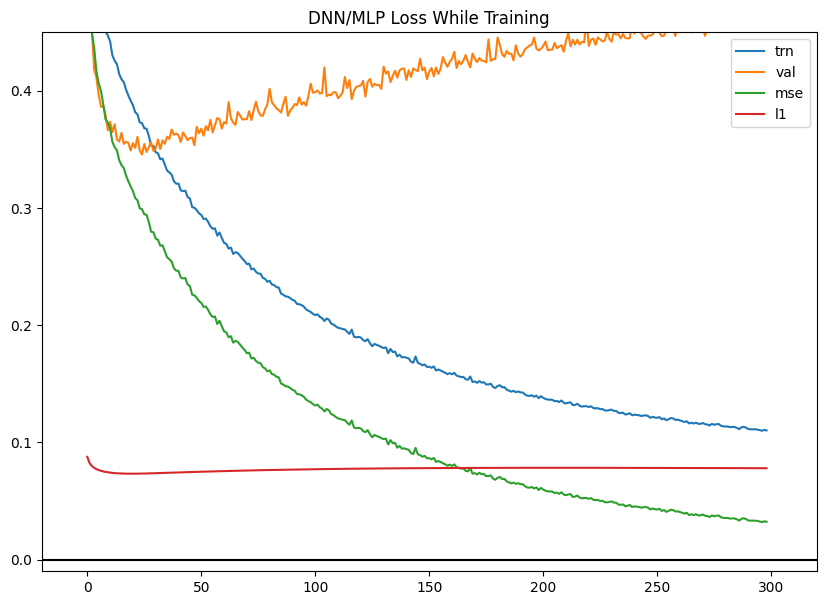

In [4]:
plt.figure(figsize=(10,7))
plt.plot(np.mean(all_losses[:k,:,0],axis=1))
plt.plot(all_val_losses[:k])
plt.plot(np.mean(all_losses[:k,:,1],axis=1))
plt.plot(np.mean(all_losses[:k,:,2],axis=1))
plt.plot([-50,EP+50],[0,0],c='k')
plt.legend(['trn','val','mse','l1'])
plt.xlim(-20,EP+20)
plt.ylim(-.01,.45)
plt.title("DNN/MLP Loss While Training")
plt.show()

## Finding Feature Interactions

In [5]:
from basic_wrappers import MixedModelWrapperTorch
device=torch.device("cpu")

model_wrap_MLP = MixedModelWrapperTorch(net1, device)

In [6]:
from aggregate_detections import aggregateContrastiveDetections_only1D, aggregateContrastiveDetections_only2D
from notebook_utils import prettyPrintInteractionSingles,prettyPrintInteractionPairs

finding and plotting the one-dimensional interaction/ main effects

In [7]:
AGG_K=100
agg_1,mains_1,grads_1,_ = aggregateContrastiveDetections_only1D(model_wrap_MLP,valX1,AGG_K)

	 0
	 10
	 20
	 30
	 40
	 50
	 60
	 70
	 80
	 90


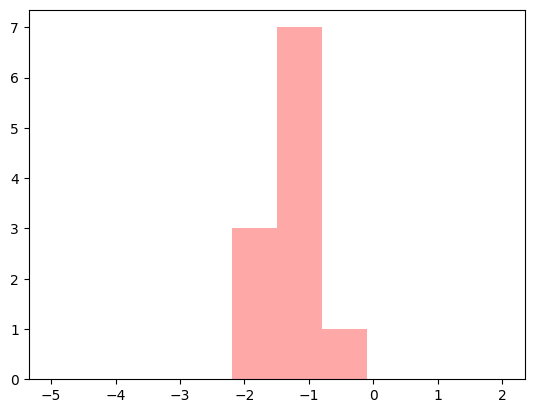

In [8]:
bins = np.linspace(-5,2,11)
plt.hist(np.log(list(agg_1.values())),color='r',alpha=.34,bins=bins)
plt.show()

In [9]:
prettyPrintInteractionSingles(agg_1,readable_labels)

Top Accumulated 1D Interactions
-------------------------------
10
alcohol        ;
		 0.5766017603670691

2
citric acid    ;
		 0.43338497053951713

9
sulphates      ;
		 0.4117212239302766

6
total sulfur dioxide;
		 0.3204834933794164

8
pH             ;
		 0.3174738928767464

0
fixed acidity  ;
		 0.304550471553271

7
density        ;
		 0.28090457009036734

1
volatile acidity;
		 0.27826582075589323

3
residual sugar ;
		 0.18176831909260602

5
free sulfur dioxide;
		 0.1812254343308031

4
chlorides      ;
		 0.17877414042128026



finding and plotting the two-dimensional interaction effects

In [10]:
AGG_K=100
agg_2,mains_2,grads_2,_ = aggregateContrastiveDetections_only2D(model_wrap_MLP,valX1,AGG_K)

	 0
	 10
	 20
	 30
	 40
	 50
	 60
	 70
	 80
	 90


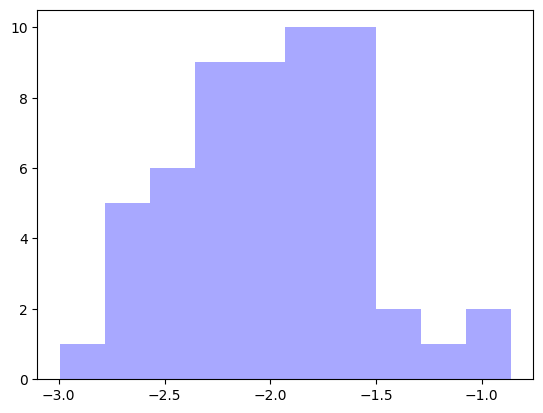

In [19]:
bins = np.linspace(-5,2,11)
plt.hist(np.log(list(agg_2.values())),color='b',alpha=.34)
plt.show()

In [20]:
prettyPrintInteractionPairs(agg_2,readable_labels)

Top Accumulated 2D Interactions
-------------------------------
0 2
fixed acidity  ; citric acid    
		 0.4219093503696812

2 10
citric acid    ; alcohol        
		 0.37356509336451416

9 10
sulphates      ; alcohol        
		 0.3281372919575859

2 7
citric acid    ; density        
		 0.27277279183505754

8 10
pH             ; alcohol        
		 0.23263562889126158

2 8
citric acid    ; pH             
		 0.2207689762695101

0 10
fixed acidity  ; alcohol        
		 0.20088007372945066

1 3
volatile acidity; residual sugar 
		 0.19995476209476162

7 9
density        ; sulphates      
		 0.1984658403926142

7 10
density        ; alcohol        
		 0.19801359907729466

1 10
volatile acidity; alcohol        
		 0.18820197642126532

0 8
fixed acidity  ; pH             
		 0.18391262501906294

8 9
pH             ; sulphates      
		 0.18387553579692809

2 6
citric acid    ; total sulfur dioxide
		 0.18367862472401

7 8
density        ; pH             
		 0.1823709919134441

6 10
total sulfu

## Training a SIAN-2 Generalized Additive Model

feel free to exchange these indices for a different set
and explore the effects of changing the available interactions

can compare to the families of indices used in Figure 2 of the paper

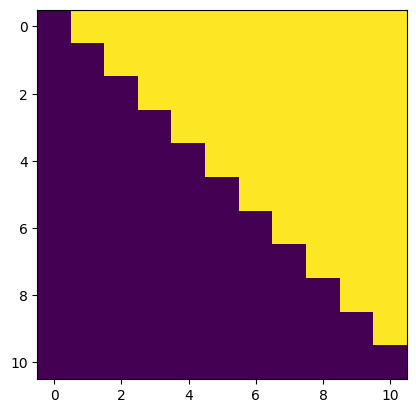

In [15]:
indices1 = [(i,) for i in range(10)]
indices2 =[(0, 2), (2, 10), (9, 10), (2, 7), (8, 10), (2, 8), (0, 10), (1, 3), (7, 9), (7, 10), (1, 10), (0, 8), (8, 9), (2, 6), (7, 8), (6, 10), (5, 10), (1, 2), (2, 3), (5, 6), (2, 4), (6, 8), (0, 9), (0, 7), (6, 9), (1, 6), (2, 5), (2, 9), (3, 7), (1, 7), (3, 9), (0, 4), (0, 6), (1, 8), (0, 5), (4, 7), (5, 9), (3, 10), (1, 9), (4, 5), (5, 7), (6, 7), (0, 1), (3, 6), (4, 10), (1, 5), (5, 8), (4, 6), (4, 8), (3, 8), (4, 9), (1, 4), (3, 4), (0, 3), (3, 5)]
indices = []
indices.extend(indices1)
indices.extend(indices2)

D = 11
interactions_matrix = np.zeros((D,D),dtype=int)
for (i,j) in indices2:
    interactions_matrix[i,j] = 1
plt.imshow(interactions_matrix) #plot of the interactions we are using
plt.show()

In [16]:
from models import *
from data_loader import loadDataset



#batch size, epochs, learning rate
BS = 32
EP = 300
LR = 5e-3

data_path = 'data/'
trnX1,trnY1,    tstX,tstY = loadDataset(data_path)

#whitening the input and output data
trnX1 = trnX1 - np.expand_dims(np.mean(trnX1,axis=0),axis=0)
trnX1 = trnX1 / np.expand_dims(np.sqrt(np.mean(trnX1**2,axis=0)),axis=0)
trnX1_og = trnX1    
trnY1_og = trnY1[:,None]-4.42

device = torch.device("cuda:0")
device = torch.device("cpu")


#for mn in range(5):
if True:
    mn=0
    M_NUM = trnX1_og.shape[0]
    rand_indices = np.random.permutation(M_NUM)
    per = .7
    M_TRN_NUM = int(M_NUM*per)
    trnX1 = trnX1_og[rand_indices[:M_TRN_NUM]]
    trnY1 = trnY1_og[rand_indices[:M_TRN_NUM]]
    valX1 = trnX1_og[rand_indices[M_TRN_NUM:]]
    valY1 = trnY1_og[rand_indices[M_TRN_NUM:]]


    trn_data1 = TensorDataset(torch.from_numpy(trnX1).float().to(device),
                              torch.from_numpy(trnY1).float().to(device))
    trn_loader1 =DataLoader(dataset=trn_data1, batch_size=BS,shuffle=True)

    trn_tensor = torch.from_numpy(trnX1).float().to(device)
    val_tensor = torch.from_numpy(valX1).float().to(device)


    sizes = [11,256,128,64,1]
    sian_net1 = SIAN(sizes,indices,False).to(device)
    
    opt1 = optim.Adagrad(sian_net1.parameters(), lr = LR)
    
    
    all_trn_accs = np.zeros(EP)
    all_val_accs = np.zeros(EP)
    all_losses = np.zeros((EP,len(trn_loader1),7))
    all_trn_losses = np.zeros((EP,len(trn_loader1)))
    all_val_losses = np.zeros(EP)

    best_val_score = -100
    best_net2 = None

    full_training_start_time = time.time()
    for k in range(EP):
        print('Epoch',k)
        start_time = time.time()

        
        #---TRAINING PHASE---
        for j,(x_batch,y_batch) in enumerate(trn_loader1):
            sian_net1.train()
            logits = sian_net1(x_batch)
            dnn_logits,gam_logits,shape_loss = sian_net1(x_batch)
            logits = dnn_logits + gam_logits
            

            l1_reg = torch.zeros(1).to(device)
            all_linear_params = sian_net1.collectParameters()
            lambda1 = 5e-5 
            l1_reg = lambda1 * torch.norm(all_linear_params, 1)


            mseloss = (y_batch.narrow(1,0,1) - logits.narrow(1,0,1))**2
            mseloss = torch.mean(mseloss)
            mseloss = mseloss
            
            
            all_trn_losses[k,j] = mseloss.item()
            loss = mseloss + l1_reg
            loss.backward()
            all_losses[k,j,0] = loss.item()
            all_losses[k,j,1] = mseloss.item()
            all_losses[k,j,2] = l1_reg.item()
            
            
            opt1.step()
            opt1.zero_grad()
        print('mean training loss\t',np.mean(all_losses[k,:,0]))
        
        
        #---VALIDATION PHASE---
        print('epoch',k,'\'')
        sian_net1.eval()
        #training accuracy
        logits = sian_net1(trn_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_trn_accs[k] = np.mean(((trnY1[:,0])-logits)**2)
        #validation accuracy
        logits = sian_net1(val_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_val_accs[k] = np.mean(((valY1[:,0])-logits)**2)
        all_val_losses[k] = np.mean(((valY1[:,0])-logits)**2)
        print('MSE for train and val\t',all_trn_accs[k],'\t',all_val_accs[k])


        
        if k%1==0:
            val_score = -all_val_accs[k]
            if val_score > best_val_score:
                best_val_score = val_score
                best_net2 = copy.deepcopy(sian_net1)

        end_time = time.time()
        print("--- %s seconds in epoch ---" % round((end_time - start_time),3))
        print()
    print('FULLY TRAINED USING',time.time()-full_training_start_time,'seconds')
    print()
    

Epoch 0
mean training loss	 2.9965699868542806
epoch 0 '
MSE for train and val	 0.5282728930646969 	 0.5909714233708664
--- 0.834 seconds in epoch ---

Epoch 1
mean training loss	 0.635947200868811
epoch 1 '
MSE for train and val	 0.4612729276719965 	 0.5186342544513293
--- 0.725 seconds in epoch ---

Epoch 2
mean training loss	 0.5846645725624902
epoch 2 '
MSE for train and val	 0.4325971453809974 	 0.48881989754921457
--- 0.545 seconds in epoch ---

Epoch 3
mean training loss	 0.5551530782665525
epoch 3 '
MSE for train and val	 0.4147908647073768 	 0.4691599432831488
--- 0.592 seconds in epoch ---

Epoch 4
mean training loss	 0.5388546703117234
epoch 4 '
MSE for train and val	 0.40292727816301244 	 0.4578164049778697
--- 0.914 seconds in epoch ---

Epoch 5
mean training loss	 0.5264605496610913
epoch 5 '
MSE for train and val	 0.39428935658386666 	 0.449575095542784
--- 0.611 seconds in epoch ---

Epoch 6
mean training loss	 0.5170608535408974
epoch 6 '
MSE for train and val	 0.38817

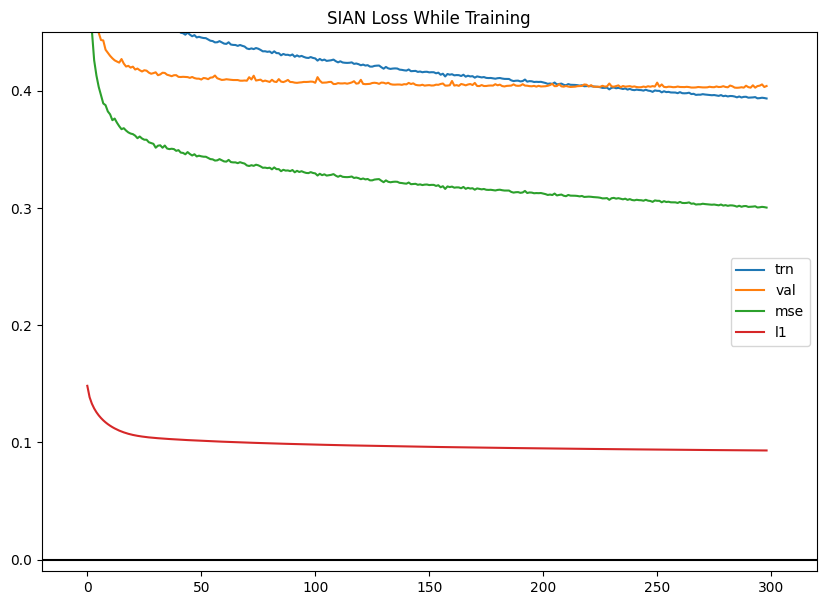

In [17]:
plt.figure(figsize=(10,7))
plt.plot(np.mean(all_losses[:k,:,0],axis=1))
plt.plot(all_val_losses[:k])
plt.plot(np.mean(all_losses[:k,:,1],axis=1))
plt.plot(np.mean(all_losses[:k,:,2],axis=1))
plt.plot([-50,EP+50],[0,0],c='k')
plt.legend(['trn','val','mse','l1'])
plt.xlim(-20,EP+20)
plt.ylim(-.01,.45)
plt.title("SIAN Loss While Training")
plt.show()